In [1]:
# !pip install --upgrade mxnet==1.6.0
# !pip install gluonts
# !pip install prophet

In [2]:
# Import libraries
import os
import numpy as np
import torch
import pandas as pd

In [3]:
# Download Electricity Dataset
file = "LD2011_2014_clean.txt"
isExist = os.path.exists(file)
if not isExist:
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
    !unzip LD2011_2014.txt.zip
    # change commas to dots
    !sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt
else: 
    print(f"Files are ready")

Files are ready


In [4]:
"""Preprocess data"""
data = pd.read_csv('LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('Data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
aggregated_data = data_2.groupby(['time']).agg(agg_dict)
print('Data aggregated by hour')
aggregated_data.shape

Data loaded..
Data aggregated by hour


(26304, 370)

In [5]:
"""Normalize data"""
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

# Check normalized data
normalized_data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,-0.767048,5.979015,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,-0.925467,-0.660711,-0.611351,-0.924599,-1.182866,0.055241,-0.298429,-0.970811,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,1.174705,2.419487,0.131533,0.362440,0.666522,1.016322,...,-0.968145,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,5.979015,0.710631,0.964851,1.573172,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,-0.289139,-0.478750,-1.119708,-1.044284,-1.312616
2012-01-01 04:00:00,-0.088516,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,-0.559453,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,-1.139759,-0.289139,-1.696712,-1.175544,-1.102634,-1.312616
2012-01-01 05:00:00,-0.141076,-0.905502,5.979015,-0.726679,-0.259294,-0.524736,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,-0.961790,-1.182866,-0.383061,-1.707784,-1.169340,-1.072133,-1.312616


In [6]:
n_clients = 370

In [7]:
# Hyper-parameters
prediction_length = 24
freq = "1H"
train_start = pd.Period("01-01-2012", freq=freq) 
test_start = pd.Period("18-12-2014", freq=freq)

/home/tung6100/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: UserWarning: Parsing '18-12-2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
"""Function to split train and test dataset"""
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:25968,:n_clients] #25600; 25968; 26082
    data_test = normalized_data.iloc[25968:25968+24,:n_clients]
    data_test_deepAR = normalized_data.iloc[:25968+prediction_length,:n_clients]
    return data_train, data_test, data_test_deepAR

In [9]:
"""Check train and test dataset"""
data_train, data_test, data_test_deepAR = set_train_test(n_clients=n_clients)
data_train.shape, data_test.shape, data_test_deepAR.shape

((25968, 370), (24, 370), (25992, 370))

In [10]:
"""Convert data to numpy"""
data_train_np = data_train.to_numpy()
data_test_np = data_test.to_numpy()
data_test_deepAR_np = data_test_deepAR.to_numpy()
data_train_np = data_train_np.T
data_test_np = data_test_np.T
data_test_deepAR_np = data_test_deepAR_np.T
# Check the type of data
type(data_train_np), data_train_np.shape, data_test_deepAR_np.shape

(numpy.ndarray, (370, 25968), (370, 25992))

In [11]:
"""

Create missing values based on normal distribution random choice

Input: 
 - pd_data: 2d pandas data frame
 - missing_percentage: missing percentage <= 100

Output:
 - return_data: 2d pandas with missed values

"""
def create_missing_data(pd_data, missing_percentage = 20):
    if missing_percentage == 0: return pd_data
    assert missing_percentage <= 100, "missing percentage should be less than or equal 100%"
    np.random.seed(1993)
    # Convert data frame to array
    np_data = pd_data.to_numpy()
    # Convert original data to 1d array - Because existing package only supports to randomly choose indices from 1d array
    np_data_1d = np_data.flatten()
    # Randomly choose missing index
    total_elem = np_data_1d.shape[0]
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False) # with replace = False, an index only is chosen 1 time
    # Replace missing_index with 0
    np_data_1d[missing_index] = 0
    # Convert 1d array to 2d array
    np_data_2d = np_data_1d.reshape(pd_data.shape[0], pd_data.shape[1])
    # Convert 2d array to dataframe
    cols_name = pd_data.columns
    return_data = pd.DataFrame(np_data_2d, columns = cols_name)
    return_data.index = pd_data.index
    return return_data

missing_df = create_missing_data(normalized_data, missing_percentage=20)
missing_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,-0.193637,0.000000,0.000000,0.750556,1.297119,2.562526,0.380006,0.420689,0.936652,1.237010,...,0.000000,-0.660711,-0.611351,-0.924599,-1.182866,0.000000,-0.298429,0.000000,-0.867907,-1.312616
2012-01-01 02:00:00,-0.088516,-0.711666,5.979015,0.723940,0.000000,0.000000,0.131533,0.362440,0.000000,1.016322,...,0.000000,-0.718147,-0.862776,-0.926923,-1.177477,-0.195217,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,-0.193637,-0.739357,0.000000,0.710631,0.000000,0.000000,0.090121,-0.263732,0.500288,0.616982,...,-1.023433,-0.710625,-0.879452,-0.931572,-1.177477,0.000000,0.000000,-1.119708,-1.044284,0.000000
2012-01-01 04:00:00,0.000000,-0.877811,5.979015,-0.194342,0.037999,0.059340,-0.179057,-0.948152,0.000000,-0.391876,...,-1.228097,-0.732505,-0.896128,-0.957141,0.000000,-0.289139,0.000000,-1.175544,0.000000,-1.312616
2012-01-01 05:00:00,0.000000,-0.905502,5.979015,-0.726679,-0.259294,0.000000,-0.365412,-1.297643,-0.351661,-0.539002,...,-1.179598,-0.753702,-0.901901,0.000000,-1.182866,0.000000,-1.707784,-1.169340,0.000000,-1.312616


In [12]:
missing_percentage = 60
data_train_missing_vals = create_missing_data(data_train, missing_percentage=missing_percentage)
data_train_missing_vals.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,0.0,0.000000,0.000000,0.750556,0.000000,0.0,0.000000,0.000000,0.936652,0.000000,...,0.000000,0.000000,0.000000,-0.924599,-1.182866,0.000000,-0.298429,0.000000,-0.867907,-1.312616
2012-01-01 02:00:00,0.0,-0.711666,5.979015,0.723940,0.000000,0.0,0.000000,0.362440,0.000000,0.000000,...,0.000000,-0.718147,-0.862776,-0.926923,-1.177477,0.000000,-0.111780,-0.964607,-0.923605,-1.312616
2012-01-01 03:00:00,0.0,-0.739357,0.000000,0.000000,0.000000,0.0,0.000000,-0.263732,0.500288,0.616982,...,0.000000,0.000000,-0.879452,0.000000,0.000000,0.000000,0.000000,0.000000,-1.044284,0.000000
2012-01-01 04:00:00,0.0,0.000000,0.000000,0.000000,0.037999,0.0,-0.179057,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.957141,0.000000,-0.289139,0.000000,-1.175544,0.000000,0.000000
2012-01-01 05:00:00,0.0,-0.905502,0.000000,0.000000,-0.259294,0.0,0.000000,0.000000,0.000000,-0.539002,...,-1.179598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.169340,0.000000,0.000000


In [13]:
data_train_missing_vals.iloc[:, :n_clients].to_numpy().shape

(25968, 370)

In [14]:
"""Convert data to numpy"""
data_train_np = data_train_missing_vals.iloc[:, :n_clients].to_numpy()
data_test_np = data_test.iloc[:, :n_clients].to_numpy()
data_test_deepAR_np = data_test_deepAR.iloc[:, :n_clients].to_numpy()
data_train_np = data_train_np.T
data_test_np = data_test_np.T
data_test_deepAR_np = data_test_deepAR_np.T
# Check the type of data
type(data_train_np), data_train_np.shape, data_test_np.shape, data_test_deepAR_np.shape

(numpy.ndarray, (370, 25968), (370, 24), (370, 25992))

In [15]:
"""Create dataset for Gluont"""
from gluonts.dataset.common import ListDataset
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": train_start} for x in data_train_np],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": train_start} for x in data_test_deepAR_np], freq=freq
)

In [16]:
from gluonts.model.prophet import ProphetPredictor
from gluonts.mx import Trainer

Importing plotly failed. Interactive plots will not work.


In [17]:
estimator = ProphetPredictor(prediction_length=prediction_length,)

In [18]:
predictor = estimator.predict(train_ds, num_samples=1)

In [19]:
predictions = list(predictor)
predictions[0].samples

15:17:42 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:53 - cmdstanpy - INFO - Chain [1] start processing
15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:39 - cmdstanpy - INFO - Chain [1] start processing
15:18:42 - cmdstanpy - INFO - Chain [1] done processing
15:18:44 - cmdstanpy - INFO - Chain [1] start processing
15:18:52 - cmdstanpy - INFO - Chain [1] done processing
15:18:53 - cmdstanpy - INFO - Chain [1] start processing
15:18:57 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:11 - cmdstanpy - INFO - Chain [1] done processing
15:19:13 - cmdstanpy - INFO - Chain [1] start processing
15:19:17 - cmdstanpy - INFO - Chain [1] done processing
15:19:18 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1]

array([[-1.65018071, -0.2458595 , -1.16093839,  0.02623417, -0.39036267,
        -0.98859207,  0.40562442, -0.43054247, -0.64718667, -0.97011425,
         0.25480397, -0.3509469 , -0.04183472, -0.25771257, -0.52863203,
         0.60526571, -1.01446449, -0.9089017 , -0.75570654, -0.33702122,
         0.08298065, -0.66540976, -0.12404785, -0.30772645]])

In [21]:
# Convert gluont package into a numerical list
predictions_list = []
for prediction in predictions:
  predictions_list.append(prediction.samples)
predictions_np = np.array(predictions_list)
predictions_np = predictions_np.reshape(n_clients, 24)
predictions_np.shape

(370, 24)

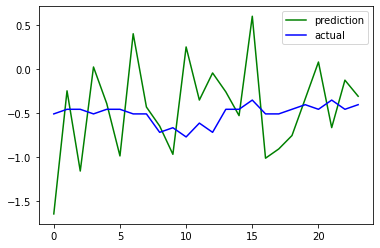

In [22]:
# Check prophet results
import matplotlib.pyplot as plt

prediction_0 = predictions_np[0]
actual_0 = data_test_np[0, :24]

plt.plot(prediction_0, color='g', label="prediction")
plt.plot(actual_0, color='b', label="actual")
plt.legend()
plt.show()

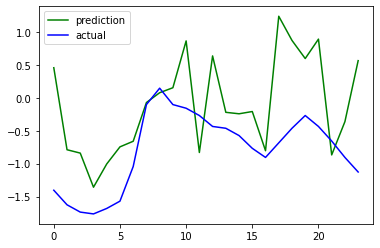

In [23]:
import matplotlib.pyplot as plt

prediction_1 = predictions_np[1]
actual_1 = data_test_np[1, :24]

plt.plot(prediction_1, color='g', label="prediction")
plt.plot(actual_1, color='b', label="actual")
plt.legend()
plt.show()

In [24]:
# Calculate RMSE
actual_data = data_test_np[:, :24]
rmse = np.sqrt(np.mean(np.square(actual_data - predictions_np)))
rmse

0.9602448551743415

In [ ]:
# import matplotlib.pyplot as plt

In [ ]:
# prediction_0 = predictions[0].samples.reshape(-1)
# actual_0 = data_test_np[0, :24]

# plt.plot(prediction_0, color='g', label="prediction")
# plt.plot(actual_0, color='b', label="actual")
# plt.legend()
# plt.show()

In [ ]:
# prediction_1 = predictions[1].samples.reshape(-1)
# actual_1 = data_test_np[1, :24]

# plt.plot(prediction_1, color='g', label="prediction")
# plt.plot(actual_1, color='b', label="actual")
# plt.legend()
# plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
def evaluate_Testset(y_true, y_pred):
    def mape(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mae(y_true, y_pred)
    MAPE = mape(y_true, y_pred)
    return MSE, RMSE, MAE, MAPE

def accuracy_Testset(y_true, y_pred):
  diff_pred = list()
  diff_true = list()
  accuracy = 0.
  for i in range(len(y_true)-1):
      diff_pred.append(y_pred[i+1]-y_pred[i])
      diff_true.append(y_true[i+1]-y_true[i])
  count = sum(diff_pred[i] * diff_true[i] > 0 for i in range(len(diff_pred)))
  accuracy = count/len(diff_pred) * 100
  return accuracy

In [26]:
MSE, RMSE, MAE, MAPE = evaluate_Testset(actual_data, predictions_np)
print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}")

MSE: 0.9220701818887926, RMSE: 0.9602448551743418, MAE: 0.740799280639405, MAPE: 320.9551783077655
